In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [2]:
import json
import pandas as pd
import numpy as np
import time
import heapq

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
likes_path = "/content/drive/MyDrive/Tesi/easytour-likes-2022-03MAR-21.json"
schede_path = "/content/drive/MyDrive/Tesi/easytour-schede-2022-03MAR-21.json"
#data_path = "/content/drive/MyDrive/Tesi/data_analyzed.csv"
data_path = "/content/drive/MyDrive/Tesi/data.csv"

In [5]:
df_schede = pd.read_json(schede_path)
df_likes = pd.read_json(likes_path)
data = pd.read_csv(data_path, encoding_errors='ignore')  

In [6]:
df_schede_fields = df_schede[["id","userId", "title", "description", "duration", "datePublishing", "creationDate", "counterUseful", "categories", "viewCounter"]]
df_likes_ids = df_likes[["id", "userId"]]

In [7]:
data

,id,userId,title,description,duration,datePublishing,creationDate,counterUseful,viewCounter,aria aperta,cultura,food,sport,tempo libero,viaggi,duration_min,days
0,62355f98272ae5672fbc3ac7,632,['spiaggia'],"['paradiso', 'amant', 'sole', 'mare', 'sole', ...",0.0,2022-03-19T04:44:09.503Z,2022-03-19T04:44:08.000+00:00,0,2.0,0,0,0,0,0,1,0.0,9
1,620abb33ff8ae67f37cafe3c,442,[],"['spiaggia', 'isola', 'spiaggia', 'mare', 'ter...",3600000.0,2022-02-14T20:27:32.224Z,2022-02-14T20:27:31.000+00:00,0,413.0,0,0,0,0,0,1,60.0,41
2,620aa536ff8ae67f37cafb06,442,['tigr'],"['marcio', 'maltrattamento', 'animal', 'sconsi...",3600000.0,2022-02-14T20:05:09.586Z,2022-02-14T18:53:42.000+00:00,0,414.0,0,0,0,0,0,1,60.0,41
3,62349ff2272ae5672fbc3135,632,['big'],"['meta', 'turista', 'assalto', 'spiaggia', 'ac...",0.0,2022-03-19T04:48:49.248Z,2022-03-18T15:06:26.000+00:00,0,4.0,0,0,0,0,0,1,0.0,10
4,6234aa65272ae5672fbc34c2,632,"['wat', 'tempio']","['spiaggia', 'pena', 'tempio', 'big', 'tempio'...",0.0,2022-03-19T04:04:27.356Z,2022-03-18T15:51:01.000+00:00,0,4.0,0,0,0,0,0,1,0.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4351,61f57f62306802033034ceed,536,"['avventura', 'cascata']","['esperienza', 'step', 'contatto', 'realtà', '...",259200000.0,2022-01-29T17:54:42.761Z,2022-01-29T17:54:42.000+00:00,0,42.0,0,0,0,0,0,1,4320.0,57
4352,61f668fa306802033034d239,536,['avventura'],"['spalla', 'esperienza', 'lascito', 'vista', '...",57600000.0,2022-01-30T10:31:22.977Z,2022-01-30T10:31:22.000+00:00,0,35.0,0,0,0,0,0,1,960.0,57
4353,620bbf26b1675d6cc11232f8,431,"['loma', 'polmon']","['mese', 'sole', 'capital', 'nuvola', 'nebbia'...",9000000.0,2022-02-15T14:56:39.554Z,2022-02-15T14:56:38.000+00:00,1,37.0,0,0,0,0,0,1,150.0,41
4354,61f3c6add91e9928f6e0922a,431,['lima'],"['angolo', 'turista', 'calor', 'gent', 'bellez...",172800000.0,2022-02-01T16:57:01.557Z,2022-01-28T10:34:21.000+00:00,1,51.0,0,0,0,0,0,1,2880.0,59


# Tf-Idf

In [8]:
def compute_tfidf_category(data, category:str):
  tfidf_vectorizer = TfidfVectorizer(lowercase=False,
                                          min_df=3,
                                          max_df=0.25)
  # description and title are put together
  data_category = data[data[category]!=0]
  text = data_category['description'] + data_category['title']
  tfidf_schede = tfidf_vectorizer.fit_transform(text)
  dense_text = tfidf_schede.todense()
  denselist_text = dense_text.tolist()

  dataset_text_tfidf = pd.DataFrame(denselist_text, index=data_category.index,
                                    columns=tfidf_vectorizer.get_feature_names())

  return dataset_text_tfidf

In [9]:
# categories = ["aria aperta", "cultura", "food", "sport", "tempo libero", "viaggi"]
# category = "food"
# df_tfidf = compute_tfidf_category(data, category=category)
# df_tfidf

In [10]:
categories = ["aria aperta", "cultura", "food", "sport", "tempo libero", "viaggi"]
tfidf_dict = dict()
for c in categories:
  tfidf_dict[c] = compute_tfidf_category(data, category=c)

In [35]:
tfidf_dict["food"]

,10,180,abbacchio,abbinamento,abbondanza,abbuffata,abilità,abitant,abitazion,abito,...,zia,zio,zoccolett,zona,zucca,zucchero,zucchin,zucchina,zuppa,zuppetta
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0
34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.140543,0.0,0.102703,0.0,0.0,0.00000,0.0
56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.105997,0.0,0.0,0.00000,0.0
66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.218150,0.0,0.0,0.00000,0.0
4263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0
4269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0
4309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.23489,0.0


# Embeddings

## Word2Vec

## Transformers

# Recommender systems

## **Method \#1**

**Method #1:** Recommend posts that are similar to the ones that the user liked -> use cosine similarity on tf-idf

In [ ]:
df_likes_ids.userId.drop_duplicates().isin(data.userId.drop_duplicates())

0        True
1        True
3        True
5        True
6       False
        ...  
1338    False
1425     True
1458    False
1459    False
1468    False
Name: userId, Length: 116, dtype: bool

In [ ]:
#list of user
users = pd.concat([df_likes_ids.userId, data.userId]).drop_duplicates() #some ids in likes are not in posts -> some users liked posts but not posted one
#list of posts' id
posts = data.id
#list of users and posts they liked
users_likes = df_likes_ids.groupby("userId").id.apply(list)
users_likes

userId
114    [61447a3224c29e59fe4c06ab, 61824f5f21889d3548f...
119    [6172da4472b6f336088b932b, 6218ec9f29ef4a75805...
129    [615acf21eb3bf47494b8e64b, 61aa039788b2e606829...
149    [61faf5d953a6a72116188d5b, 61f41fe330680203303...
150    [61b72f34e364b82f2ac8c88c, 61f3c801d91e9928f6e...
                             ...                        
630    [62215a990a0ebd53f7469748, 62174fea99163528c06...
632                           [6229df13aeb26768dc408e81]
637    [6212993a4f9d177c90f3830f, 6224bdb835684f072b2...
639                           [620a39a4e7ce7d5992612316]
640    [622aeada99fd4c40442f3082, 6217ab40ae6735171d5...
Name: id, Length: 116, dtype: object

In [ ]:
cosine_sim = cosine_similarity(df_tfidf, df_tfidf)

In [ ]:
def get_recommendations(user_id: int):
    # Get the index of the user that we want to recommend posts to
    user_id_idx = df_schede[df_schede == user_id].index[0]
    # Get the pairwise similarity scores of all posts with that user
    sim_scores = list(enumerate(cosine_sim[user_id_idx]))
    # Sort the posts based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores of the 5 most similar posts
    sim_scores = sim_scores[1:6]
    # Get the blog post ids
    post_ids = [i[0] for i in sim_scores]
    # Return the blog posts
    return df_schede.iloc[post_ids]

def print_recommendations(recommended_posts):
    for i in range(len(recommended_posts)):
        print("Post #" + str(i+1) + ":")
        print("Post ID: " + str(recommended_posts.iloc[i].id))
        print("Title: " + str(recommended_posts.iloc[i].title))
        print("Description: " + str(recommended_posts.iloc[i].description))
        print("\n")

In [ ]:
id = 632
#print("Posts that user {} liked:".format(id))
liked_posts = df_likes_ids[df_likes_ids["userId"] == id]
#print(liked_posts)
print("Posts:")
for _,p in liked_posts.iterrows():
    post = df_schede[df_schede["id"]== p["id"]]
    if not post.description.empty:
        print(post.title)
        print("-"*100)

Posts:
92    Bemo - immergiti nella vita locale indonesiana
Name: title, dtype: object
----------------------------------------------------------------------------------------------------


In [ ]:
recommended_posts = get_recommendations(id)
print_recommendations(recommended_posts)

Post #1:
Post ID: 620675bcb1d0940f12255a3a
Title: Piazza Tienanmen
Description: Piazza Tienanmen con i suoi 440.000 metri quadrati è la piazza pubblica più grandi del mondo: può ospitare circa un milione di persone al suo interno. 

Data la vicinanza con il Palazzo dell'Assemblea Nazionale, la piazza è recintata e circondata da polizia e forze armate. Durante i congressi o gli eventi politici importanti è spesso chiusa al pubblico, talvolta anche senza preavviso.

Potete salire sulla Porta della Pace Celeste (Porta Tienanmen, da dove il ritratto di Mao guarda la città) e guardare tutta la piazza dall'alto, oppure passeggiare in mezzo ai turisti cinesi che rendono omaggio a Mao Zedong e ai caduti.

Noi andiamo durante il 70esimo anniversario e la polizia è ovunque! Tutti i percorsi sono guidati e i controlli sono a tappeto! Comprensibile ma decisamente eccessivo!! 

Ho una sola foto in mente quando si parla di piazza tienenmen….ovvero quella con i carri armati fermati da un giovane ribe

## **Method \#2**

**Method #2:** Given a user, shown him the posts that are more similar to the ones he wrote 

In [11]:
#list of user
users = pd.concat([df_likes_ids.userId, data.userId]).drop_duplicates()
#list of posts' id
posts = data.id
#list of users and posts they made
users_posts = data.groupby("userId").id.apply(list)
users_posts

userId
77     [6154833edee05f1877c59be1, 615c2b85eb3bf47494b...
119    [60f6d6864250196f9f64270c, 60f6d2f54250196f9f6...
129    [61408190533f2f326b89392b, 6140834d533f2f326b8...
149    [6190e32f068a0f468cc78c24, 620fd14f4f9d177c90f...
150    [61c9f24721c95d5d9109316d, 62263e1161e055356b8...
                             ...                        
632    [62355f98272ae5672fbc3ac7, 62349ff2272ae5672fb...
633                           [621cf9fc2fd07a48dd9f139d]
637    [621fe10a82ed1d1eef3a495c, 6228ffd7aeb26768dc4...
640    [622f6e2d46ef2b6d71a8deb7, 622b7950c992ca28f33...
642                           [623318fe0e1ee15c013192a1]
Name: id, Length: 142, dtype: object

In [29]:
data_with_ids = data.drop(columns=["datePublishing", "creationDate", "duration", "description", "title", "counterUseful", "viewCounter"])

In [12]:
X = data.drop(columns=["id", "userId", "description", "title", "datePublishing", "creationDate", "duration", "counterUseful", "viewCounter"])

In [13]:
X

,aria aperta,cultura,food,sport,tempo libero,viaggi,duration_min,days
0,0,0,0,0,0,1,0.0,9
1,0,0,0,0,0,1,60.0,41
2,0,0,0,0,0,1,60.0,41
3,0,0,0,0,0,1,0.0,10
4,0,0,0,0,0,1,0.0,10
...,...,...,...,...,...,...,...,...
4351,0,0,0,0,0,1,4320.0,57
4352,0,0,0,0,0,1,960.0,57
4353,0,0,0,0,0,1,150.0,41
4354,0,0,0,0,0,1,2880.0,59


### Clusters

In [14]:
#Plot data using SVD
def plot_with_SVD(data, categories:list, tfidf_dict:dict):
  svd_dict = dict()
  for c in categories:
    tfidf = tfidf_dict[c]
    data_with_tfidf = pd.concat([data[data[c]!=0], tfidf], axis=1)
    data_with_tfidf.drop(columns=categories, inplace=True)
    svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
    svd = svd.fit_transform(data_with_tfidf)
    svd_dict[c] = svd
    plt.scatter(svd[:,0], svd[:,1])
    plt.title("Category: " + c)
    plt.show()
  return svd_dict

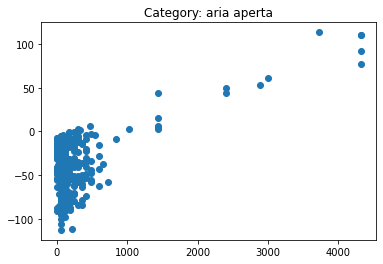

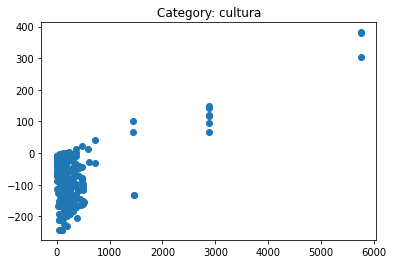

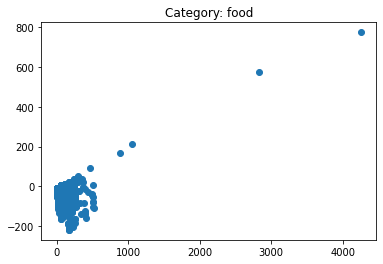

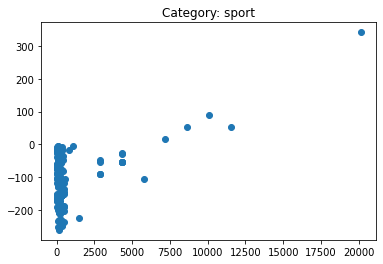

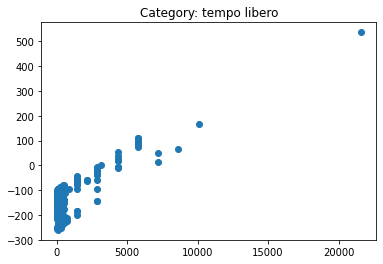

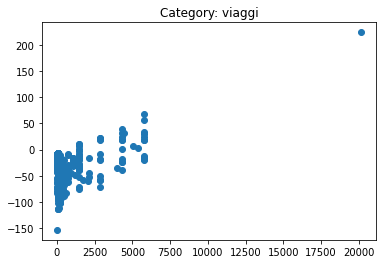

In [15]:
svd_dict = plot_with_SVD(X, categories, tfidf_dict)

In [16]:
#Plot results
def plotKMeans(label, df, category):
  u_labels = np.unique(label)
  for i in u_labels:
      plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
  plt.title('K-means with {} clusters for {}'.format(len(u_labels), category))
  plt.legend()
  plt.show()

In [17]:
def kmeans_tests(data, category, svd_dict, clusters_number=10, steps=1):
  inertia = []
  times = dict() #{k:time_needed}
  K = range(2,clusters_number,steps) 
  for k in K:
      #Fit 
      start = time.time()
      kmeanModel = KMeans(n_clusters=k)
      kmeans = kmeanModel.fit(data)
      time_needed = time.time() - start
      times[k] = time_needed
      #Elbow
      inertia.append(kmeanModel.inertia_)
      #Clusters
      label = kmeans.predict(data)
      plotKMeans(label, svd_dict[category], category)
  return inertia, times, K

In [18]:
def elbow_and_statistics(inertia, times, K):
  #Elbow
  plt.figure(figsize=(10,3))
  plt.plot(K, inertia, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Inertia')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()
  print("\n")
  #Inertia
  for k,value in zip(K, inertia):
    print("Inertia for {} clusters is: {}".format(k,value))
  print("\n")
  #Times needed
  for k,v in times.items():
    print("Time needed to fit kmeans with {} clusters is: {}".format(k,v))

In [19]:
from yellowbrick.cluster import KElbowVisualizer
def elbow_visualizer(data, k):
  model = KMeans()
  visualizer = KElbowVisualizer(model, k=k)
  visualizer.fit(X)        
  visualizer.show() 

In [46]:
def kmeans_computation(data, tfidf_dict, categories:list, svd, k, visualizer=False):
  assert type(categories)==list, "Expected list as input not {}".format(type(categories))
  for c in categories:
    print("Category: {}".format(c))
    tfidf = tfidf_dict[c]
    data_category = pd.concat([data[data[c]!=0], tfidf], axis=1)
    data_cleaned = data_category.drop(columns=categories)
    if visualizer:
      #kmeans
      inertia, times, K = kmeans_tests(data_cleaned, c, svd, k)
      # Elbow and inertia
      elbow_and_statistics(inertia, times, K)
    else:
      elbow_visualizer(data_cleaned, k)  

Category: aria aperta


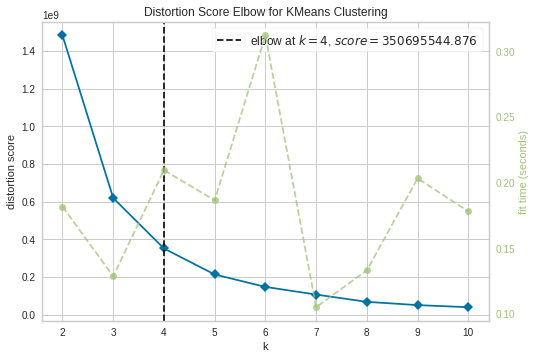

Category: cultura


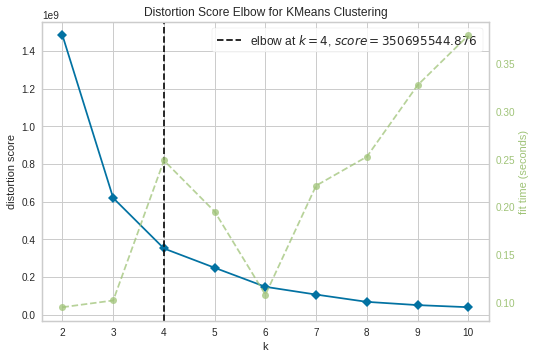

Category: food


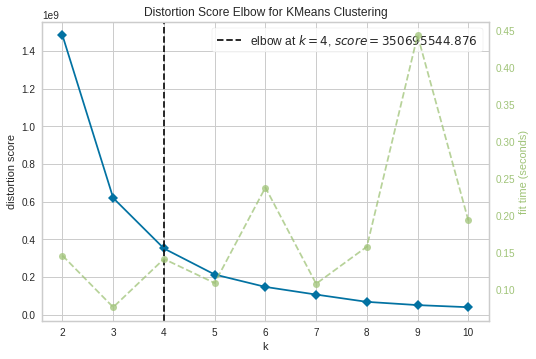

Category: sport


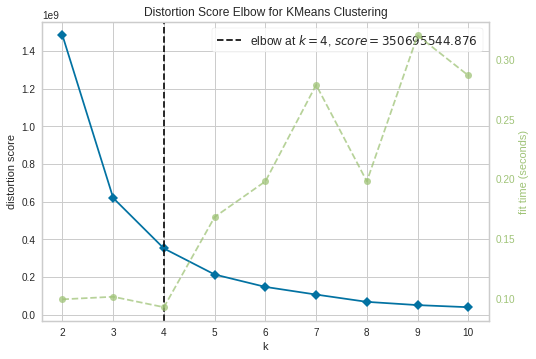

Category: tempo libero


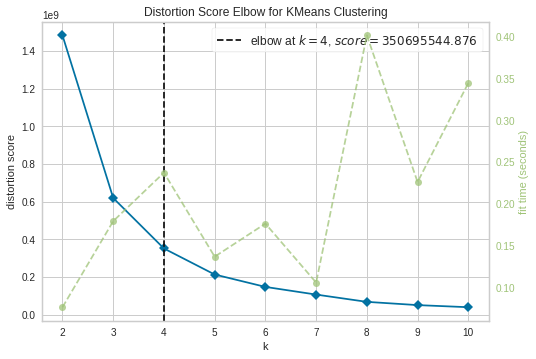

Category: viaggi


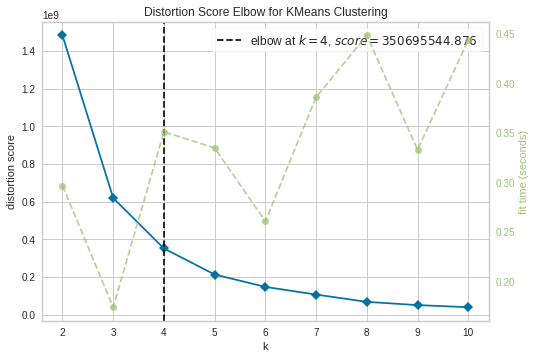

In [47]:
#kmeans_computation(["food"])
kmeans_computation(X, tfidf_dict, categories, svd_dict, 10)

### Cluster Consenus

In [55]:
optimal_number_clusters = {"aria aperta":4, "cultura":4, "food":4, "sport":4, "tempo libero":4, "viaggi":4}
#optimal_number_clusters = {"aria aperta":3, "cultura":3, "food":3, "sport":3, "tempo libero":3, "viaggi":3}

In [56]:
kmeans_dict = dict()
for k,v in optimal_number_clusters.items():
  kmeanModel = KMeans(n_clusters=v)
  print("Category '{}' has {} clusters".format(k,v))
  #data_category = X[X[k] == 1]
  tfidf = tfidf_dict[k]
  data_category = pd.concat([X[X[k]!=0], tfidf], axis=1)
  data_cleaned = data_category.drop(columns=categories)
  kmeans = kmeanModel.fit(data_cleaned.values)
  kmeans_dict[k] = kmeans
  #print number of posts in each cluster
  labels = kmeans.labels_
  count_elem_per_cluster = pd.DataFrame(labels).value_counts()
  print(count_elem_per_cluster)
  print()

Category 'aria aperta' has 4 clusters
0    584
3     72
2      8
1      7
dtype: int64

Category 'cultura' has 4 clusters
0    687
3     61
1      6
2      3
dtype: int64

Category 'food' has 4 clusters
1    792
0    277
3     21
2      2
dtype: int64

Category 'sport' has 4 clusters
0    293
1     13
3      4
2      1
dtype: int64

Category 'tempo libero' has 4 clusters
0    489
3     28
1     14
2      1
dtype: int64

Category 'viaggi' has 4 clusters
0    693
1     59
3     25
2      1
dtype: int64



In [119]:
from itertools import groupby

def get_similarity(t):
  return t[0]

def ranking_target(target_categories):
  scores_clusters = [(cat, len(s)) for cat, cluster in target_categories.items() for s in cluster.values()]
  scores_categories = []
  for i, g in groupby(sorted(scores_clusters), key=lambda x: x[0]):
      scores_categories.append([i, sum(v[1] for v in g)])
  scores_categories.sort(key=lambda x: x[1], reverse=True)
  return scores_categories

def similarity(target_user, partitions_users, top=5):
  ranking = ranking_target(partitions_users[target_user])
  for k,v in partitions_users.items():
    if k == target_user:
      continue 
    for c in categories:
      user_category_score = [len(s) for cluster in v.values() for s in cluster]
      

# def similarity(target_user, partitions_users, top=5):
#   # Creating empty heap
#   heap = []
#   heapq.heapify(heap)
#   # number of target_user's posts in each cluster and total number of target's post
#   if target_user not in partitions_users:
#     print("Id not valid!")
#     return
#   target_categories = partitions_users[target_user]
#   target_scores_categories = [len(s) for cluster in target_categories.values() for s in cluster]
#   print(target_scores_categories)
#   number_posts_target = sum(target_scores_categories)
#   for k,v in partitions_users.items():
#     if k == target_user:
#       continue
#     user_scores = [len(x) for x in v.values()]
#     distance = sum([abs(x-y) for x,y in zip(target_scores_categories, user_scores)])
#     number_posts_user = sum(user_scores)
#     total_posts = number_posts_target + number_posts_user
#     similarity = 1 - (distance/total_posts)
#     heapq.heappush(heap, (similarity, k))
#   return heapq.nlargest(top, heap, key=get_similarity) 


In [118]:
id = 129
best_users = similarity(id, partitions_by_user)
best_users

{'cultura': {3: ['6140834d533f2f326b893934', '618e78a6a5feeb0440a7f21f'], 0: ['6172750ae22ccc1544bdf871', '620e5934af16656930950491', '61b62d2005808c2d13e1e741', '62179358ae6735171d5c0010', '61fff76375551f4dc5a6ca81', '61cc4d53ce6c9f22d7eb599a', '61685bf027d0877f5c2126b4', '623057d046ef2b6d71a8fd5c']}, 'food': {3: ['6169aaa1e5b812488d8c15f5', '614883f97e37495794603dcf'], 0: ['61c20d8d8618d1271acb8957', '61cedd33520d2828ac3d2bc6', '61f7f3f0de25614ef958a3d2', '6207e528b1d0940f122582db', '619a25f427fd10380bb5d652', '61a0f1230783552ab94e19b2', '61e19a6602eda64de31b066a', '6184f4e6f08309502229eed3', '618535f2de2f885f7e6a04a0', '61f26e16d91e9928f6e086ef', '61b9b844f847ed27e4497a29', '612366abed242d4ae012fe69', '61aa06dc88b2e606829dc3a0'], 1: ['61a1027b0783552ab94e1b73', '620bd59b9af0354e9c14b064', '6214fc1a6a759d6ff9284444', '622228bfb0d2b615ae781fc1', '61ed90ec8e21a6510547593c', '6230b0184a745d44ac4e653f']}, 'sport': {0: ['60f6e120968bc30656b1d7fd', '615c7d4ceb3bf47494b8e73a', '61f5677b3068

Considering posts users wrote

In [89]:
def posts_in_partition(data, users, categories, kmeans_dict):
  partitions = dict()
  for c in categories:
    tfidf = tfidf_dict[c]
    data_category = pd.concat([data[data[c]!=0], tfidf], axis=1)
    data_post = data_category.drop(columns=categories)
    users = data_post["userId"]
    posts_ids = data_post["id"]
    data_post = data_post.drop(columns=["userId", "id"])
    for u,p,d in zip(users, posts_ids, data_post.iterrows()):
      user = u
      post = p
      features = d[1]
      cluster = kmeans_dict[c].predict([features.values])[0]
      if user in partitions:
          #check if category c already exists for userId
          if c in partitions[user]:
            #check if cluster already exists for the category c of userId
            if cluster in partitions[user][c]:
              partitions[user][c][cluster].append(post)
            else:
              partitions[user][c][cluster] = [post]
          else:
            partitions[user][c] = dict()
            partitions[user][c][cluster] = [post]
      else:
        partitions[user] = dict()
        partitions[user][c] = dict()
        partitions[user][c][cluster] = [post]
  return partitions

In [90]:
partitions_by_user = posts_in_partition(data_with_ids, users, categories, kmeans_dict)

In [67]:
# # compute distribution of the posts in the clusters for each user
# # partitions = {user1: {"food": {c0:[post1, post4], c1:[post6], c2:[post3]}, "viaggi":{co:[], c1:[post100], c2:[]}, etc}, user2...}
# def posts_in_partition(data, users, categories, kmeans_dict):
#   partitions = dict()
#   for u in users:
#     #userId = row["userId"]
#     posts_user = X[data["userId"] == u]
#     #a post can have multiple categories
#     for _, p in posts_user.iterrows():
#       for c in categories:
#         if p[c] != 1:
#           continue
#         #data_category = posts_user[posts_user[c] == 1] 
#         tfidf = tfidf_dict[c]
#         data_category = pd.concat([posts_user[posts_user[c]!=0], tfidf], axis=1)
#         data_post = data_category.drop(columns=categories)
#         cluster = kmeans_dict[c].predict(data_post.values)
#         #cluster = kmeans.predict([X.iloc[index]])
#         if u in partitions:
#           #check if category c already exists for userId
#           if c in partitions[u]:
#             #check if cluster already exists for the category c of userId
#             if cluster in partitions[u][c]:
#               partitions[u][c][cluster].append(row["id"])
#             else:
#               partitions[u][c][cluster] = [row["id"]]
#           else:
#             partitions[u][c] = dict()
#             partitions[u][c][cluster] = [row["id"]]
#         else:
#           partitions[u] = dict()
#           partitions[u][c] = dict()
#           partitions[u][c][cluster] = [row["id"]]
#     # if userId in partitions:
#     #   if cluster[0] in partitions[userId]:
#     #     partitions[userId][cluster[0]].append(row["id"])
#     #   else:
#     #     partitions[userId][cluster[0]] = [row["id"]]
#     # else:
#     #   partitions[userId] = {}
#     #   partitions[userId][cluster[0]] = [row["id"]]
#   return partitions

In [95]:
def print_info_partitions_for_user(user, partition):
  print("Info about the clusters for the posts of user {}".format(user))
  partitions_categories = partition[user]
  for category,partitions in partitions_categories.items():
    print("Clusters for category {}: {}".format(category, len(partitions)))
    for cluster,array in partitions.items():
      print("#items in cluster {} for category {}: {}".format(cluster, category, len(array)))
    print()

In [ ]:
# partitions_by_user = posts_in_partition(data_with_ids, users, categories, kmeans_dict)

In [102]:
print_info_partitions_for_user(77, partitions_by_user)

Info about the clusters for the posts of user 77
Clusters for category cultura: 1
#items in cluster 3 for category cultura: 1

Clusters for category sport: 1
#items in cluster 0 for category sport: 1

Clusters for category tempo libero: 1
#items in cluster 0 for category tempo libero: 1



In [ ]:
id = 77
best_users = similarity(id, partitions_by_user)
best_users

Considering the posts the users liked

In [ ]:
# compute distribution of the likes in the clusters for each user
# partitions = {user1: {c0:[like1, like4], c1:[like6], c2:[like3]}, user2:{c0:[], c1:[]}, etc}
def likes_in_partition():
  partitions = dict()
  for _, row in df_likes_ids.iterrows():
    userId = row["userId"]
    post = row["id"]
    index = pd.Index(data[data["id"] == post])
    cluster = kmeans.predict(X[data["id"] == post].values)
    if userId in partitions:
      if cluster[0] in partitions[userId]:
        partitions[userId][cluster[0]].append(row["id"])
      else:
        partitions[userId][cluster[0]] = [row["id"]]
    else:
      partitions[userId] = {}
      partitions[userId][cluster[0]] = [row["id"]]
  return partitions

In [ ]:
def print_info_partitions_for_user_likes(user, partition):
  print("Info about the clusters for the likes of user {}".format(user))
  clusters = partition[user]
  print("Number of different clusters: {}".format(len(clusters)))
  for k,v in clusters.items():
    print("Cluster {} contains {} likes".format(k, len(v)))
    #print("Posts' ids: {}".format(v))

In [ ]:
partitions_by_user_likes = likes_in_partition()

In [ ]:
print_info_partitions_for_user_likes(129, partitions_by_user_likes)

In [ ]:
id = 129
best_users = similarity(id, partitions_by_user_likes)
best_users

Print the recommendations

In [ ]:
def print_results(data, users):
  for u in users:
    posts = data[data["id"]==u[1]]
    print("User: {}".format(u))
    for p in posts.iterrows():
      print("Post:")
      print(p.description)
    print("-"*100)

In [ ]:
print_results(df_schede, best_users)